In [106]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
import seaborn as sns
import itertools
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [107]:
import itertools

import warnings
warnings.filterwarnings('ignore')

In [108]:
df = pd.read_csv("Datasets/all_diseases.csv.gz")
df.loc[(df.disease.isin(['dengue'])) & 
       (df.no_cases.isin([-45491.0])), 
       'no_cases'] = 45491.0

In [109]:

# Mean Absolute Percentage Error (MAPE)
# Mean Error (ME)
# Mean Absolute Error (MAE)
# Mean Percentage Error (MPE)
# Root Mean Squared Error (RMSE)
# Lag 1 Autocorrelation of Error (ACF1)
# Correlation between the Actual and the Forecast (corr)
# Min-Max Error (minmax)



def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
#     acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 
#             'acf1':acf1, 
            'corr':corr, 'minmax':minmax})


In [110]:
us_data_dengue = df[df.country.str.lower().str.contains('america|united states') &
                    df.disease.isin(['dengue'])]

us_data_dengue.date = pd.to_datetime(us_data_dengue.date)

us_data_dengue.pivot_table(index=us_data_dengue.date.dt.year, 
                               columns = us_data_dengue.date.dt.month, 
                               values = 'no_cases', 
                               aggfunc='sum')

date,1,2,3,4,5,6,7,8,9,10,11,12
date,,,,,,,,,,,,
2015,3.0,0.0,113.0,27.0,39.0,55.0,73.0,98.0,77.0,130.0,197.0,133.0
2016,169.0,72.0,69.0,43.0,83.0,70.0,161.0,114.0,82.0,60.0,38.0,29.0
2017,32.0,18.0,12.0,16.0,19.0,23.0,68.0,64.0,54.0,71.0,44.0,32.0
2018,4.0,10.0,14.0,6.0,7.0,16.0,29.0,32.0,77.0,27.0,55.0,54.0
2019,11.0,36.0,31.0,16.0,26.0,9.0,91.0,184.0,221.0,220.0,159.0,154.0
2020,17.0,34.0,32.0,24.0,17.0,-5.0,41.0,41.0,25.0,18.0,38.0,25.0


In [111]:
us_data_dengue.country.value_counts()

United States of America    313
Name: country, dtype: int64

In [112]:
fit_data = us_data_dengue[['date','no_cases']]
train_data = fit_data[(fit_data.date >= pd.to_datetime('2015-01-01')) & 
                      (fit_data.date <= pd.to_datetime('2018-12-31'))].set_index('date')

predict_data = fit_data[fit_data.date.dt.year.isin([2019,2020])].set_index('date')

## Using the auto arima

In [113]:
from pmdarima.arima import auto_arima

In [114]:
auto_arima_model = auto_arima(train_data[['no_cases']].fillna(method="bfill"), random_state=42)
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  209
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -758.938
Date:                Sun, 01 Aug 2021   AIC                           1521.876
Time:                        09:50:09   BIC                           1528.551
Sample:                             0   HQIC                          1524.575
                                - 209                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6830      0.033    -20.429      0.000      -0.748      -0.617
sigma2        86.1922      1.577     54.639      0.000      83.100      89.284
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):             27419.51
Prob(Q):                              0.93   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                             5.53
Prob(H) (two-sided):                  0.00   Kurtosis:                        58.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [115]:
auto_arimaprediction = pd.DataFrame(auto_arima_model.predict(len(predict_data)),index=predict_data.index)
auto_arimaprediction.columns = ['Predicted']

<AxesSubplot:title={'center':'Actual vs Forecast'}, xlabel='date'>

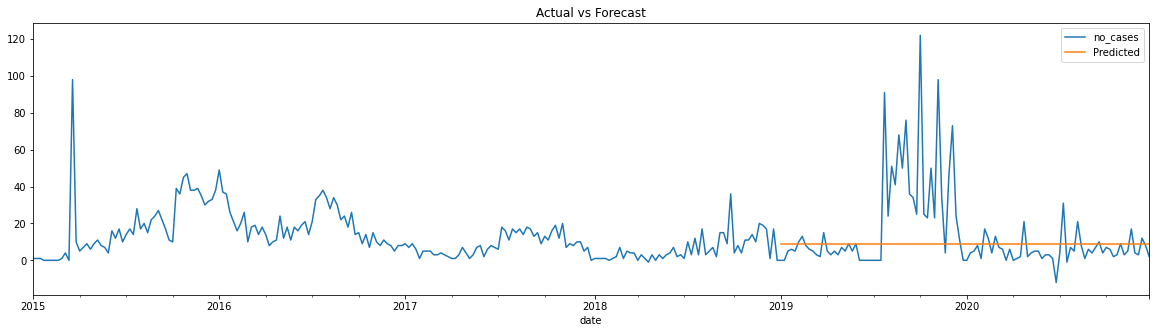

In [116]:
ax = fit_data.set_index('date').plot(y='no_cases',figsize=(20,5),title='Auto Arima Actual Vs Forecasted')
auto_arimaprediction.plot(y='Predicted',figsize=(20,5),title='Actual vs Forecast', ax=ax)

<AxesSubplot:title={'center':'Actual vs Forecast'}, xlabel='date'>

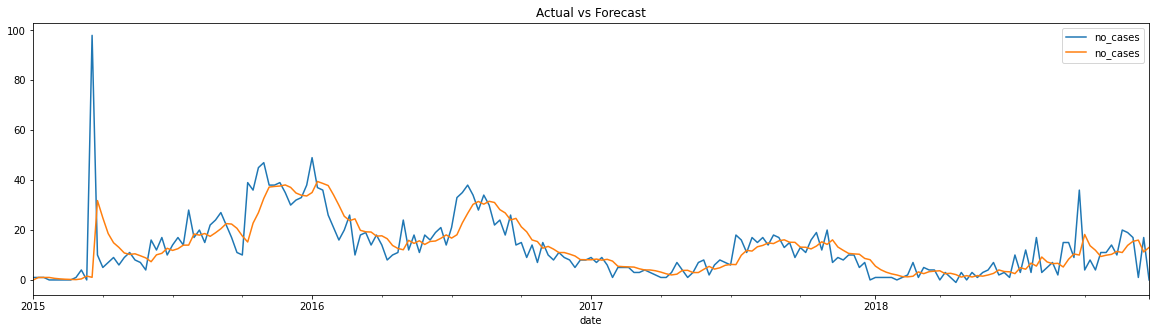

In [117]:
# Checking model fit on train data

trainfitpredict = pd.DataFrame(auto_arima_model.predict_in_sample(), index=train_data.index)
trainfitpredict.columns = ['no_cases']

ax = train_data.plot(y='no_cases',figsize=(20,5),title='Actual Vs Forecasted')
trainfitpredict.plot(y='no_cases',figsize=(20,5),title='Actual vs Forecast', ax=ax)

# Classic Arima

In [118]:
def aic_for_orders(train, pdq_values):
    train = train.astype('float32')
    ordersaic_d = {}
    for current_pdq in pdq_values:
        cur_model = ARIMA(train, order=current_pdq)
        cur_results = cur_model.fit()
        cur_aic = cur_results.aic
        ordersaic_d[current_pdq] = cur_aic
    return ordersaic_d

def get_arima_predictions(train, test, order):
    predictions = list()
    for step in range(len(test)):
        model = ARIMA(train,order=order)
        fit_model = model.fit()
        prediction = fit_model.forecast().values[0]
        timestamp = test.index[step]
        predictions.append((timestamp, prediction))
        train = train.append(test.iloc[step])
    preds_frame = pd.DataFrame(predictions).set_index([0]).rename(columns={1:'Predictions'})
    return preds_frame

In [119]:
p = d = q = range(0,4)
pdqlist = list(itertools.product(p, d, q))
newordersaic_d = aic_for_orders(train=train_data[['no_cases']].fillna(method="bfill"), pdq_values=pdqlist)

[Text(0.5, 0, 'orders'),
 Text(0, 0.5, '%'),
 Text(0.5, 1.0, 'pdq values and aic scores')]

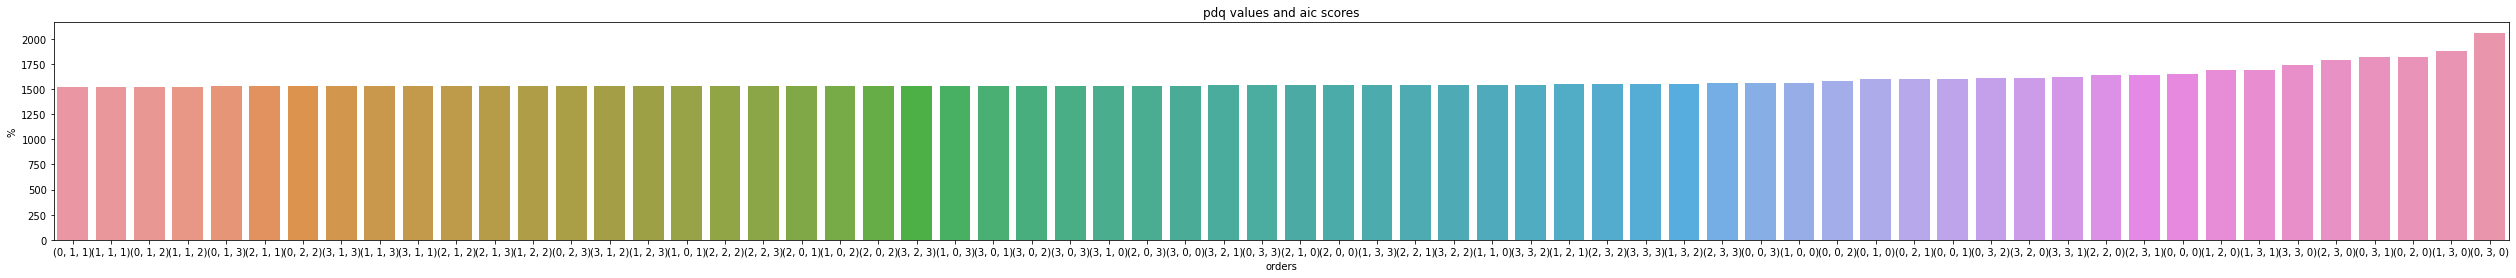

In [120]:
orders_andaic = pd.DataFrame(newordersaic_d.items(),columns=['orders','aic']).sort_values(by='aic',ascending=True)

fig_dims = (44, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='orders', y='aic', data=orders_andaic)
ax.set(xlabel = 'orders', ylabel='%', title='pdq values and aic scores')

In [121]:
orders_andaic.head()

,orders,aic
5,"(0, 1, 1)",1521.875525
21,"(1, 1, 1)",1523.872342
6,"(0, 1, 2)",1523.872994
22,"(1, 1, 2)",1524.170838
7,"(0, 1, 3)",1524.562231


In [122]:
arima_test_predictions = get_arima_predictions(train_data[['no_cases']],
                                               predict_data[['no_cases']],
                                              order=(0,1,1))

In [123]:
arima_test_predictions.head()

,Predictions
0,
2019-01-06,8.913051
2019-01-13,6.018417
2019-01-20,4.022851
2019-01-27,4.346623
2019-02-03,4.885838


In [124]:
fit_data[fit_data.date.dt.year.isin([2019])].head()

,date,no_cases
158919,2019-01-06,0.0
158920,2019-01-13,0.0
158921,2019-01-20,5.0
158922,2019-01-27,6.0
158923,2019-02-03,5.0


<AxesSubplot:title={'center':'Actual vs Forecast'}, xlabel='0'>

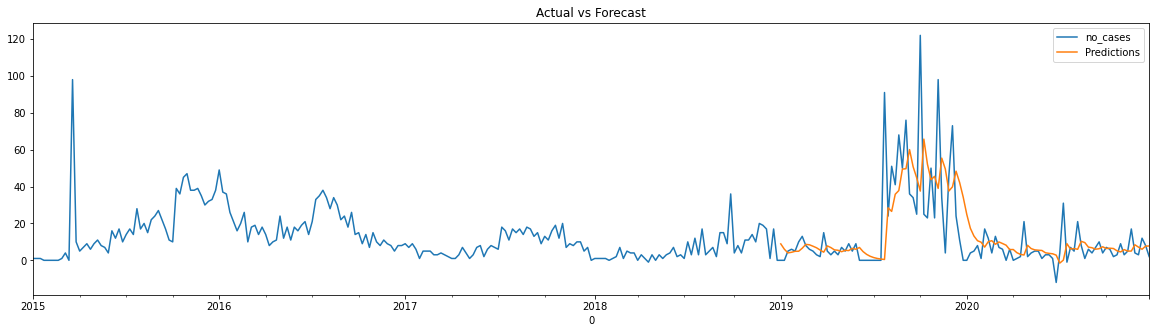

In [125]:
ax = fit_data.set_index('date').plot(y='no_cases',figsize=(20,5),title='Actual Vs Forecasted')
arima_test_predictions.plot(y='Predictions',figsize=(20,5),title='Actual vs Forecast', ax=ax)

In [126]:
forecast_accuracy(arima_test_predictions['Predictions'], predict_data['no_cases'])

{'mape': inf,
 'me': 0.320277111297617,
 'mae': 10.265805035968386,
 'mpe': inf,
 'rmse': 18.577808792207843,
 'corr': 0.5743405056947924,
 'minmax': 0.5582977359876367}

In [127]:
df = pd.read_csv("Datasets/all_diseases.csv.gz")
df.loc[(df.disease.isin(['dengue'])) & 
       (df.no_cases.isin([-45491.0])), 
       'no_cases'] = 45491.0

## ARIMA model for U.S. Covid Data

In [134]:
us_data_covid = df[df.country.str.lower().str.contains('america') &
                       df.disease.isin(['covid-19'])]

us_data_covid.date = pd.to_datetime(us_data_covid.date)

fit_data = us_data_covid[['date','no_cases']]
train_data = fit_data[(fit_data.date.dt.year.isin([2020])) &
                      (fit_data.date.dt.month>5)].set_index('date')

predict_data = fit_data[fit_data.date.dt.year.isin([2021])].set_index('date')

In [135]:
fit_data = us_data_covid[['date','no_cases']]
train_data = fit_data[(fit_data.date.dt.year.isin([2020])) &
                      (fit_data.date.dt.month>5)].set_index('date')

predict_data = fit_data[fit_data.date.dt.year.isin([2021])].set_index('date')

In [136]:
train_data.head()

,no_cases
date,
2020-06-01,17414.0
2020-06-02,21502.0
2020-06-03,19857.0
2020-06-04,21658.0
2020-06-05,25403.0


In [137]:
auto_arima_model = auto_arima(train_data[['no_cases']].fillna(method="bfill"), random_state=42)
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  214
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -2378.297
Date:                Sun, 01 Aug 2021   AIC                           4760.595
Time:                        10:10:46   BIC                           4767.317
Sample:                             0   HQIC                          4763.312
                                - 214                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5948      0.031    -19.414      0.000      -0.655      -0.535
sigma2      3.054e+08   1.33e-11    2.3e+19      0.000    3.05e+08    3.05e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):               901.58
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):              19.48   Skew:                            -1.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        12.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number    inf. Standard errors may be unstable.
"""

<AxesSubplot:title={'center':'Actual vs Forecast'}, xlabel='date'>

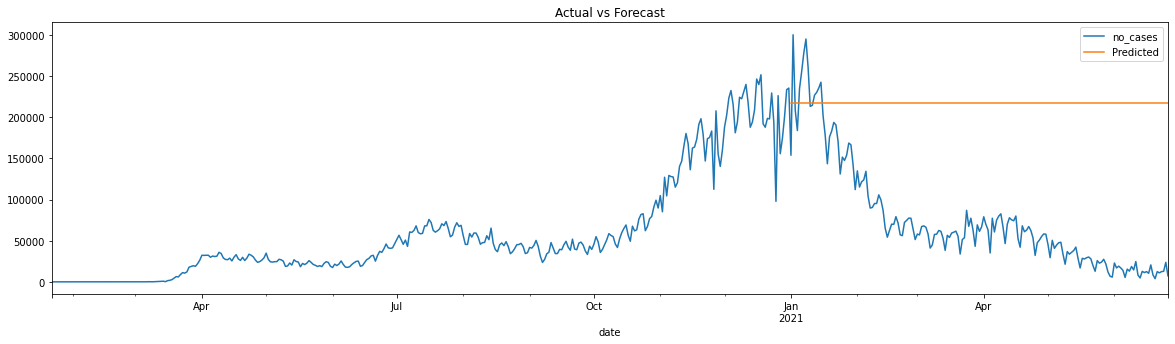

In [138]:
auto_arimaprediction = pd.DataFrame(auto_arima_model.predict(len(predict_data)),index=predict_data.index)
auto_arimaprediction.columns = ['Predicted']

ax = fit_data.set_index('date').plot(y='no_cases',figsize=(20,5),title='Auto Arima Actual Vs Forecasted')
auto_arimaprediction.plot(y='Predicted',figsize=(20,5),title='Actual vs Forecast', ax=ax)

<AxesSubplot:title={'center':'Actual vs Forecast'}, xlabel='date'>

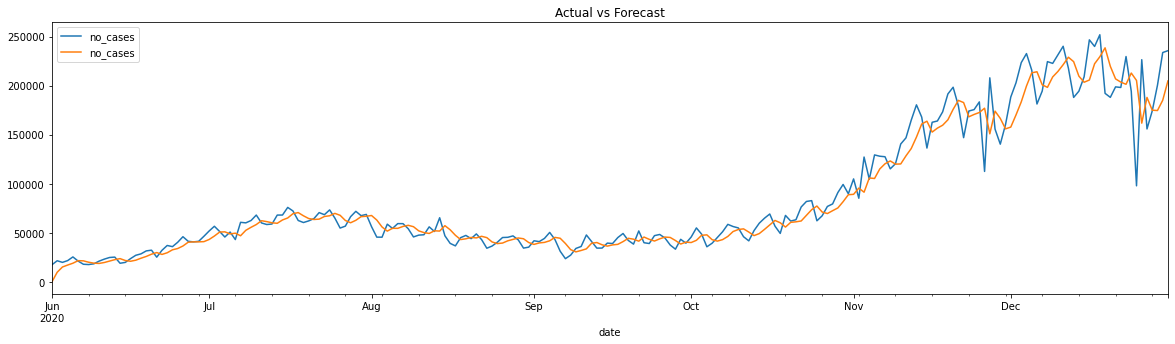

In [139]:
# Checking model fit on train data

trainfitpredict = pd.DataFrame(auto_arima_model.predict_in_sample(), index=train_data.index)
trainfitpredict.columns = ['no_cases']

ax = train_data.plot(y='no_cases',figsize=(20,5),title='Actual Vs Forecasted')
trainfitpredict.plot(y='no_cases',figsize=(20,5),title='Actual vs Forecast', ax=ax)

In [141]:
p = d = q = range(0,4)
pdqlist = list(itertools.product(p, d, q))
newordersaic_d = aic_for_orders(train=train_data.no_cases, pdq_values=pdqlist)

[Text(0.5, 0, 'orders'),
 Text(0, 0.5, '%'),
 Text(0.5, 1.0, 'pdq values and aic scores')]

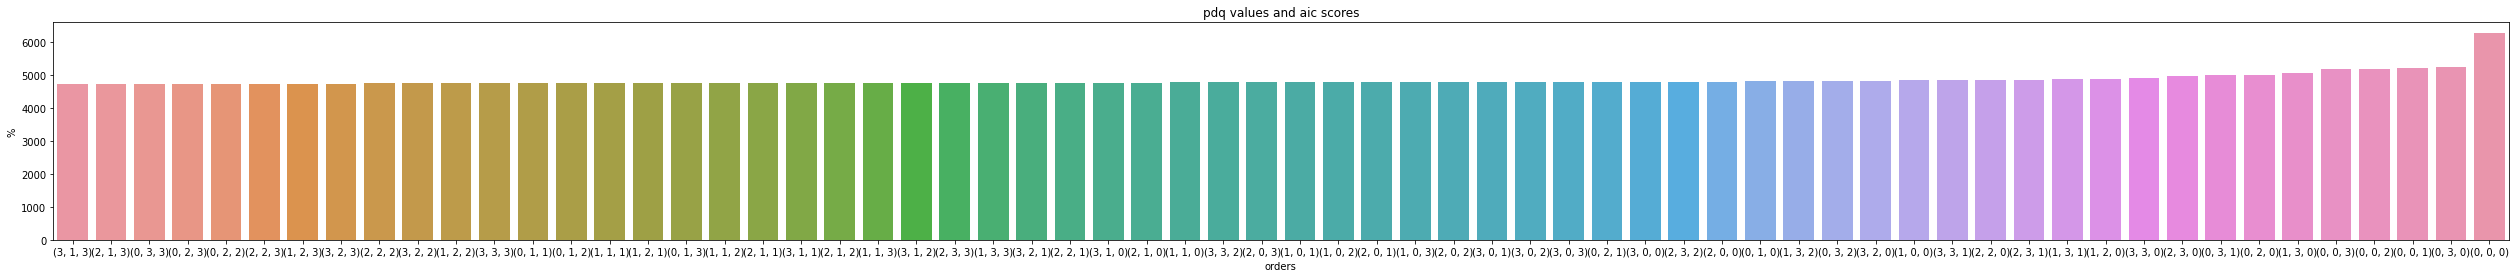

In [142]:
orders_andaic = pd.DataFrame(newordersaic_d.items(),columns=['orders','aic']).sort_values(by='aic',ascending=True)

fig_dims = (44, 4)
fig, ax = plt.subplots(figsize=fig_dims)
sns.barplot(x='orders', y='aic', data=orders_andaic)
ax.set(xlabel = 'orders', ylabel='%', title='pdq values and aic scores')

In [143]:
arima_test_predictions = get_arima_predictions(train_data[['no_cases']],
                                               predict_data[['no_cases']],
                                              order=(0,2,3))

<AxesSubplot:title={'center':'Actual vs Forecast'}, xlabel='0'>

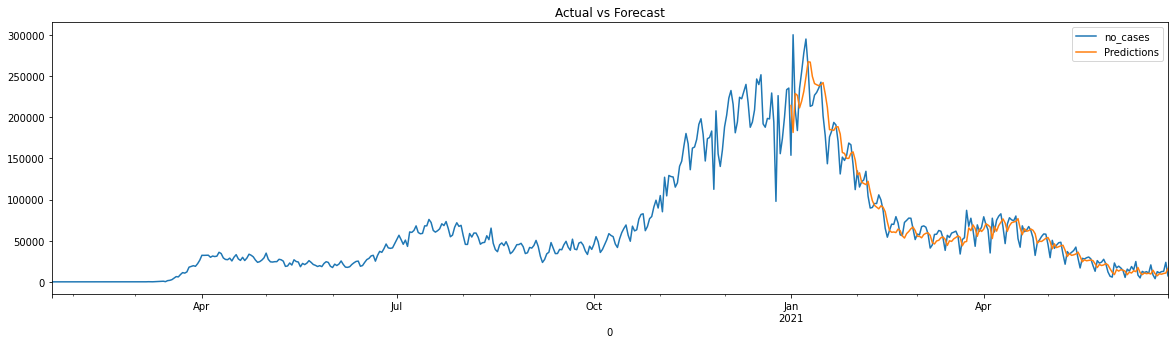

In [144]:
ax = fit_data.set_index('date').plot(y='no_cases',figsize=(20,5),title='Actual Vs Forecasted')
arima_test_predictions.plot(y='Predictions',figsize=(20,5),title='Actual vs Forecast', ax=ax)

In [145]:
forecast_accuracy(arima_test_predictions['Predictions'], predict_data['no_cases'])

{'mape': 0.23482463099550083,
 'me': 455.7365035106499,
 'mae': 11884.249876388816,
 'mpe': 0.05410453260265744,
 'rmse': 18707.46234742681,
 'corr': 0.9597348935392176,
 'minmax': 0.17744170176511365}

## ARIMA Model for ZIKA in the U.S.

In [147]:
us_data_zika = df[df.country.str.lower().str.contains('us') &
                       df.disease.isin(['zika'])]

us_data_zika.date = pd.to_datetime(us_data_zika.date)

In [148]:
fit_data = us_data_zika[['date','no_cases']]
train_data = fit_data[(fit_data.date >= pd.to_datetime('2016-11-01')) &
                      (fit_data.date <= pd.to_datetime('2017-08-31'))].set_index('date')

predict_data = fit_data[(fit_data.date >= pd.to_datetime('2017-09-01')) &
                        (fit_data.date <= pd.to_datetime('2017-12-31'))].set_index('date')

In [149]:
auto_arima_model = auto_arima(train_data[['no_cases']].fillna(method="bfill"), random_state=42)
auto_arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   88
Model:                        SARIMAX   Log Likelihood                -465.230
Date:                Sun, 01 Aug 2021   AIC                            934.460
Time:                        10:18:45   BIC                            939.415
Sample:                             0   HQIC                           936.457
                                 - 88                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     10.3864     16.338      0.636      0.525     -21.636      42.408
sigma2      2288.2371    250.564      9.132      0.000    1797.141    2779.333
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):              5511.91
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                             5.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        39.92
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

<AxesSubplot:title={'center':'Actual vs Forecast'}, xlabel='date'>

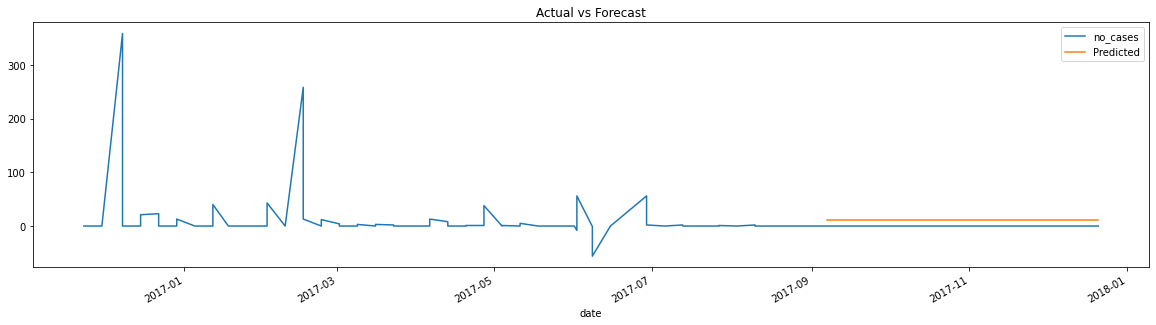

In [150]:
auto_arimaprediction = pd.DataFrame(auto_arima_model.predict(len(predict_data)),index=predict_data.index)
auto_arimaprediction.columns = ['Predicted']

ax = fit_data.set_index('date').plot(y='no_cases',figsize=(20,5),title='Auto Arima Actual Vs Forecasted')
auto_arimaprediction.plot(y='Predicted',figsize=(20,5),title='Actual vs Forecast', ax=ax)

In [152]:
forecast_accuracy(arima_test_predictions['Predictions'], predict_data['no_cases'])

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 177 and the array at index 1 has size 36